**SD5 - 1908 Messina event: a test case for adding landslide sources to the PTF**   
On December 28, 1908, an earthquake of an estimated magnitude Mw of 7.1 occurred near Messina, offshore East Sicily. The earthquake triggered a tsunami of several meters and caused at least 60,000 fatalities. The exact cause of the 1908 tsunami is not fully understood, and both earthquake and landslide source contributions provide alternative or complementary explanations.   
   
In this notebook, we use the 1908 Messina event as a test case for the mini-workflow that embeds landslide sources into the PTF.   
Before running the workflow, we precomputed the possible landslide release volumes in the area of interest, ran the numerical simulations of landslide dynamics for each release volume with the code BingClaw, followed by the numerical simulations of tsunami propagation with the code Tsunami-HySEA.    
    
The mini-workflow in this notebook follows these steps:
1. Run the first step of the PTF that generates an ensemble of earthquake scenarios and associated probabilities
2. Compute the peak ground acceleration (PGA) for each earthquake scenario (shakemaps)
3. Compute the probabilities of each precomputed release volume based on the PGA and the probability of each earthquake scenario
4. Retrieve the maximum inundation heights (MIH) from the precomputed simulations database, aggregate the probabilities, and visualize the results.
    
*See the README file for info on requirements to run the notebook and input files*

In [1]:
import os
import sys
import numpy as np
import h5py
import scipy
from scipy.stats import norm
import json

**1. Run step 1 of the PTF**   
This step create an ensemble of earthquake scenarios with different source parameters and associated probabilities

In [3]:
# Set paths of input and output directories
# local inputs
input_folder = r"P:\2022\02\20220296\Background-Others\INPUT4PTF\\"
# input data folder
data_folder = input_folder  #TODO change this?
output_folder = 'output'

# Load external functions from a Jupyter notebook
%run ./utils/ptf_functions.ipynb
%run ./utils/ptf_functions_sampling.ipynb

In [4]:
# Input parameters for the PTF
event_file_name = '1908_1228_messina.json'
workdir = './'
sigma = 1.1
sigma_inn = sigma
sigma_out = sigma + 0.5
negligible_prob = 2*norm.cdf(-1. * sigma)
sampling_nscenarios = 200

In [5]:
# Load the event file and build the event dictionary
event_file = os.path.join(input_folder,'earlyEst', event_file_name)
s = open(event_file, 'r').read()
jsn_object = eval(s)

event_dict = int_quake_cat2dict(json_object=jsn_object)

event_dict['event_file'] = event_file
event_dict['sigma'] = sigma

event_dict = compute_position_sigma_lat_lon(event_dict)
print(event_dict)

{'eventid': '19081228', 'originid': '19081228', 'lat': 37.965, 'lon': 15.487, 'depth': 15.0, 'ot': '1908-12-28T04:20', 'mag': 7.09, 'mag_percentiles': {'p16': 6.89, 'p50': 7.09, 'p84': 7.29}, 'MagSigma': 0.20000000000000018, 'type': 'earthquake', 'mag_type': 'Mwp', 'ee_utm': (542777.7386262032, 4202043.550189212, 33, 'S'), 'place': 'east_sicily', 'cov_matrix': {'XX': 13.9478, 'XY': 4.8435, 'XZ': 0.2781, 'YY': 18.1122, 'YZ': 0.1786, 'ZZ': 10.2529}, 'pos_Sigma': {'XX': 13947800.0, 'XY': 4843500.0, 'XZ': 278100.0, 'YY': 18112200.0, 'YZ': 178600.0, 'ZZ': 10252900.0}, 'ee_PosCovMat_2d': array([[13.9478,  4.8435],
       [ 4.8435, 18.1122]]), 'PosMean_2d': array([ 542777.7386262 , 4202043.55018921]), 'PosCovMat_3d': array([[13.9478,  4.8435,  0.2781],
       [ 4.8435, 18.1122,  0.1786],
       [ 0.2781,  0.1786, 10.2529]]), 'PosCovMat_3dm': array([[13947800.,  4843500.,   278100.],
       [ 4843500., 18112200.,   178600.],
       [  278100.,   178600., 10252900.]]), 'PosMean_3d': array([ 542

Total number of POIs: 1107


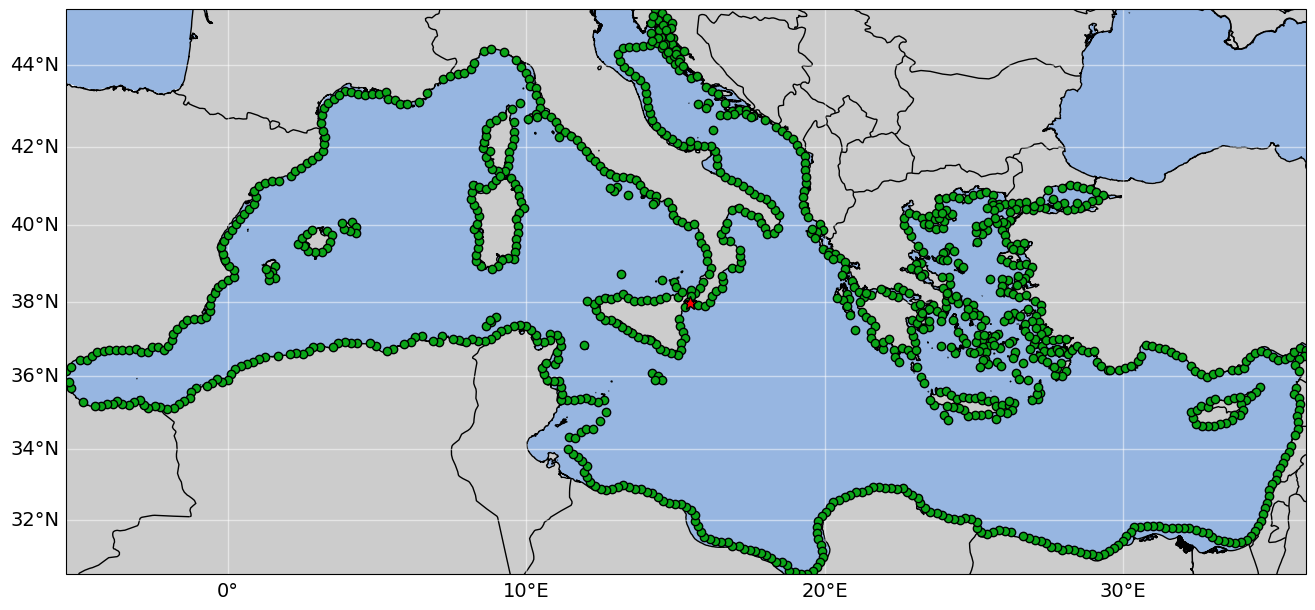

In [6]:
# Load file with coordinates of Points of Interests (POIs) and plot POIs locations
pois = np.load(os.path.join(input_folder, 'mix_npy_files','pois_messina_run.npy'), allow_pickle=True).item()
n_pois = len(pois['pois_coords'])
print(f'Total number of POIs: {n_pois}')

pois_coords = pois['pois_coords']
pois_index = np.arange(n_pois)
plot_pois(pois_coords, pois_index, event_dict)


In [7]:
# Loading input data from long term database
thresholds, intensity_measure = load_intensity_thresholds(data_folder)

LongTermInfo = dict()
LongTermInfo['Regionalization'] = np.load(os.path.join(data_folder, 'mix_npy_files','regionalization.npy'), allow_pickle=True).item()
LongTermInfo['Discretizations'] = np.load(os.path.join(data_folder, 'mix_npy_files', 'discretizations.npy'), allow_pickle=True).item()
LongTermInfo['Model_Weights'] =  load_Model_Weights(os.path.join(data_folder,'mix_npy_files'))
Region_files = load_region_files( LongTermInfo['Regionalization']['Npoly'], LongTermInfo['Regionalization']['Ttypes'], data_folder)
Mesh = np.load(os.path.join(data_folder, 'mesh_files/slab_meshes_mediterranean.npy'), allow_pickle=True).item()
PSBarInfo = np.load(os.path.join(data_folder, 'mix_npy_files', 'PSBarInfo.npy'), allow_pickle=True).item()

In [8]:
## Find BS and PS scenarios from long term database that are relevant for this event and compute the probability of each scenario
ellipses = build_ellipsoid_objects(event_dict, sigma_inn, sigma_out)
LongTermInfo, PSBarInfo = conversion_to_utm(LongTermInfo, event_dict, PSBarInfo)

# Separation BS/PS
lambda_bsps = load_lambda_BSPS(sigma, event_dict, data_folder)
lambda_bsps = separation_lambda_BSPS(event_dict, lambda_bsps, LongTermInfo, Mesh)

# Pre-selection of scenarios
pre_selection = pre_selection_of_scenarios(sigma, event_dict, LongTermInfo, PSBarInfo, ellipses)

# Compute probabilities
short_term_probability  = short_term_probability_distribution(event_dict, negligible_prob, LongTermInfo, PSBarInfo, lambda_bsps, pre_selection)
probability_scenarios = compute_probability_scenarios(LongTermInfo, pre_selection, short_term_probability, Region_files)

 --> Volume of the Gaussian Ellipsoid: 1.56945730e+12 [m^3]
 --> N. Tetra in the Gaussian Ellipsoid: 402
 --> Volume of Tetra in the Gaussian Ellipsoid: 1.43228082e+12 [m^3]
 --> Volume difference Gaussian <--> Tetra: 8.74 [%]
 --> Distance between tetra and slabs:
     --> Min distance from slab HeA    328.846 [km]
         --> Nr of PS tetra with dist.  < 10.0 [km] from slab HeA : 0  (effective: 0)
         --> Nr of BS tetra with dist. >= 10.0 [km] from slab HeA : 402  (effective: 402)
     --> Min distance from slab CaA      4.928 [km]
         --> Nr of PS tetra with dist.  < 10.0 [km] from slab CaA : 153  (effective: 153)
         --> Nr of BS tetra with dist. >= 10.0 [km] from slab CaA : 249  (effective: 249)
     --> Min distance from slab CyA   1349.779 [km]
         --> Nr of PS tetra with dist.  < 10.0 [km] from slab CyA : 0  (effective: 0)
         --> Nr of BS tetra with dist. >= 10.0 [km] from slab CyA : 402  (effective: 402)
 --> lambda PS: 3.6904e-01  Volume PS: 5.5482e

In [ ]:
# Sampling the ensemble to reduce the number of scenarios and update the probabilities (optional)
sampled_ensemble_SDE = compute_ensemble_sampling_SDE(LongTermInfo     = LongTermInfo,                                                                                                     negligible_prob  = negligible_prob,                                                                                                  pre_selection    = pre_selection,                                                                                                    regions          = Region_files,
                                                     short_term       = short_term_probability,
                                                     proba_scenarios  = probability_scenarios,
                                                     samp_scen        = sampling_nscenarios,
                                                     samp_type        = 'LH')

probability_scenarios = sampled_ensemble_SDE

Number of sampled BS scenarios: 131
Number of sampled PS scenarios: 0


In [10]:
# Saving scenario lists (parameters and probabilities)
file_bs_list = os.path.join(output_folder, 'step1_BS_scenarios_list.txt')
file_bs_prob = os.path.join(output_folder, 'step1_BS_scenarios_prob.npy')

par_scenarios_bs = probability_scenarios['par_scenarios_bs']
len_scenarios_bs, len_pars = par_scenarios_bs.shape

fmt = "{:f}".format
with open(file_bs_list, 'w') as f_list_bs:
    for ic in range(len_scenarios_bs):
        pars = " ".join(fmt(par_scenarios_bs[ic, item]) for item in range(1, len_pars))
        ireg = "{:.0f}".format(par_scenarios_bs[ic, 0])
        f_list_bs.write("{:s} {:s} {:s}\n".format(str(ic+1), ireg, pars))

prob_scenarios_bs = probability_scenarios['ProbScenBS']
np.save(file_bs_prob, prob_scenarios_bs)

print('BS scenarios saved in: {}'.format(file_bs_list))
print('BS probabilities saved in: {}'.format(file_bs_prob))

BS scenarios saved in: output\step1_BS_scenarios_list.txt
BS probabilities saved in: output\step1_BS_scenarios_prob.npy


**2. Create shakemaps for each PTF scenario**    
This step uses the earthquake source parameters from the list of scenarios generated by the step 1 of the PTF to compute a shakemap for each scenario.

In [11]:
# Converting a specially formatted *.csv data file into the required *.yaml file in the same directory
from utils.csv_to_yaml import convert_csv_to_yaml
path_to_csv = 'output/step1_BS_scenarios_list.txt'
yaml_path=convert_csv_to_yaml(path_to_csv)

Created YAML file: output/step1_BS_scenarios_list.yaml


In [12]:
import ewricagm.gm_mapping as GMmap

print('\nCalculating shapefunctions NN_MT:')
directory = os.path.dirname(yaml_path)
ensemblefile = yaml_path
config_path = 'ewricagm/configs/config_nn_mt.yaml'
GMmap.gm_mapping_read(ensemblefile, directory, config_path=config_path)
print('Finished calculating NN_MT.\n')


Calculating shapefunctions NN_MT:
33/33 [==============================] - 0s 8ms/step
Finished calculating NN_MT.



In [13]:
### Extracting only PGA (Z_pga, H_pga) from the resulting JSON file and save output
# Load the JSON data from the file
with open(f'{directory}/predicted_data_NN.json', 'r') as f:
    data = json.load(f)

# Extract the required fields
extracted_data = []
# Iterate over the values of the dictionary
for item_value in data.values():
    extracted_data.append({
        "lat": item_value.get("lat"),
        "lon": item_value.get("lon"),
        "Z_pga": item_value.get("Z_pga"),
        "H_pga": item_value.get("H_pga")
    })

# Write the extracted data to a new JSON file
with open(f'{directory}/H_Z_pda_data_log10_G.json', 'w') as f:
    json.dump(extracted_data, f, indent=2)

print(f"Data extracted and saved to {directory}/H_Z_pda_data_log10_G.json")

Data extracted and saved to output/H_Z_pda_data_log10_G.json


**3. Compute the probabilities of the landslide+tsunami scenarios**    
This step uses the shakemaps to compute the probability that each volume from the pre-computed database has to fail and produce a landslide and a subsequent tsunami.

**4. Results and visualisation**   
This step extracts the Maximum Inundation Heights (MIHs) from the pre-computed database of tsunamis simulations, aggregates the probabilities, and plots the results